In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
df = pd.read_csv('my_diabetes_data.csv')
label_encoder = LabelEncoder()
df['Diabetes'] = label_encoder.fit_transform(df['Diabetes'])
scaler_encoder = StandardScaler()
features = ['Glucose', 'BMI', 'BloodPressure', 'Insulin', 'Age']
df[features] = scaler_encoder.fit_transform(df[features])

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_x = torch.tensor(df.drop(columns=['ID', 'Diabetes']).values, dtype=torch.float32)
tensor_y = torch.tensor(df['Diabetes'].values, dtype=torch.float32).unsqueeze(1)

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
class DiabetesDataset(Dataset):
    def __init__(self, X, y) :
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [4]:
dataset = DiabetesDataset(tensor_x, tensor_y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [5]:
import torch.nn as nn

class ClassifierNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [6]:
import torch.optim as optim
model = ClassifierNN(tensor_x.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
import tqdm
num_epochs = 50
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


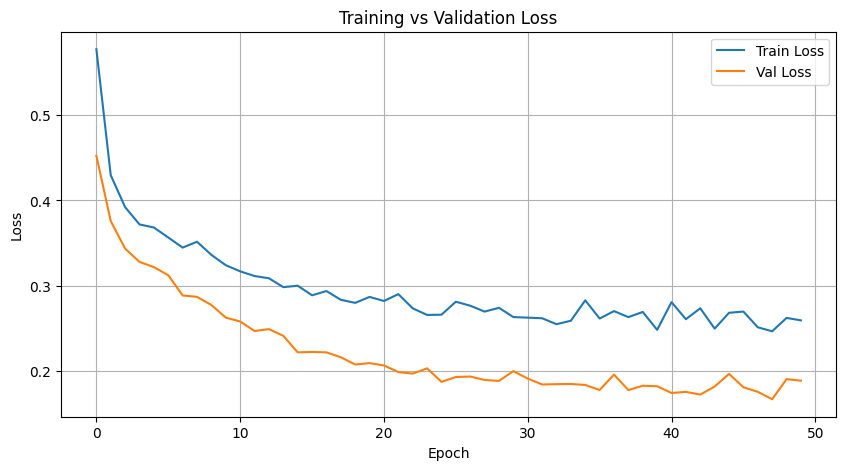

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        preds_class = (preds >= 0.5).float()
        
        all_preds.append(preds_class.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds))

# For ROC AUC, we need raw probabilities, not classes:
all_probs = []

with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_probs.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0).numpy()

print("ROC AUC:", roc_auc_score(all_labels, all_probs))

Accuracy: 0.9166666666666666
Confusion Matrix:
 [[355  35]
 [ 15 195]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       390
         1.0       0.85      0.93      0.89       210

    accuracy                           0.92       600
   macro avg       0.90      0.92      0.91       600
weighted avg       0.92      0.92      0.92       600

ROC AUC: 0.9824053724053724


---

### How to Load a Saved PyTorch Model (`best_model.pth`)

#### 1. Define the Model Architecture

PyTorch only saves the **model weights**, not the architecture.
So, you must redefine the **exact same model class** used during training:

```python
class ClassifierNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
```

---

#### 2. Recreate the Model and Load Weights

```python
# Re-create the model
input_size = X.shape[1]  # Replace with the actual input feature count
loaded_model = ClassifierNN(input_size).to(device)

# Load saved state dict
loaded_model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Set model to evaluation mode
loaded_model.eval()
```

The `map_location=device` argument ensures the model loads on the correct device (CPU or GPU).

---

#### 3. Use the Loaded Model for Inference

```python
with torch.no_grad():
    predictions = loaded_model(X_test.to(device))
    predicted_labels = (predictions >= 0.5).float()
```

---

#### 4. Optional: Check Performance

```python
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test.cpu(), predicted_labels.cpu()))
```

---

### Optional: Save and Load the Entire Model (Not Recommended)

```python
# Save the full model
torch.save(model, 'entire_model.pth')

# Load the full model
model = torch.load('entire_model.pth')
model.eval()
```

This method works but is not recommended due to potential compatibility issues across PyTorch versions. It's better to save and load only the `state_dict`.

---

| Task             | Code Example                                  |
| ---------------- | --------------------------------------------- |
| Save weights     | `torch.save(model.state_dict(), 'model.pth')` |
| Recreate model   | Define same class (`ClassifierNN`)            |
| Load weights     | `model.load_state_dict(torch.load(...))`      |
| Set to eval mode | `model.eval()`                                |
| Make predictions | `model(x)` + threshold                        |

---
